In [38]:
import torch.cuda
from flash.image import ImageClassificationData, ImageClassifier
from pytorch_lightning import seed_everything
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import torchmetrics
import flash
from pytorch_lightning.loggers import CSVLogger
from timm.loss import LabelSmoothingCrossEntropy
import time
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

In [9]:
DATA_PATH = '../../../birdclef-2022-data'
AUDIO_PATH = '../../../birdclef-2022-data/train_audio'
IMAGE_PATH = '../../../birdclef-2022-data/train_images/'
ONLY_FIRST = True
SEED = 42

# define training hyperparameters
INIT_LR = 1e-3
BATCH_SIZE = 64
EPOCHS = 10
# define the train and val splits
TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT

In [10]:
seed_everything(SEED)

Global seed set to 42


42

In [11]:
class CustomDataset(Dataset):
	def __init__(self, x, y, img_dir):
		self.x = x
		self.y = y
		self.img_dir = img_dir
		self.classes = np.unique(self.y)


	def __len__(self):
		return len(self.x)


	def __getitem__(self, idx):
		img_path = os.path.join(self.img_dir, self.x[idx])
		image = np.load(img_path)
		label = self.y[idx]
		return image, label

In [12]:
# collect data about data structure
def create_first_clip():
    all_data = []
    for primary_label in os.listdir(IMAGE_PATH):
        all_data += [primary_label + '/' +
                        x for x in os.listdir(IMAGE_PATH + primary_label) if x.endswith('_0.npy')
                        ]
    all_data += ['maupar/XC123887_1.npy']
    results = create_annotated_dataframe(all_data)
    return results

def create_all_clips():
    all_data = []
    for primary_label in os.listdir(IMAGE_PATH):
        all_data += [primary_label + '/' + x for x in os.listdir(IMAGE_PATH + primary_label)]
    results = create_annotated_dataframe(all_data)
    return results

def create_annotated_dataframe(all_data):
    base_data = {'file_name': [], 'label': []}
    for item in all_data:
        base_data['file_name'].append(item)
        base_data['label'].append(item.split('/')[0])
    results = create_encoded_dataframe(base_data)
    return results

def create_encoded_dataframe(base_data):
    results = pd.DataFrame(base_data, columns = ['file_name', 'label'])
    le = LabelEncoder()
    labels = le.fit_transform(results['label'])
    results['label'] = np.int64(labels)
    return results

In [13]:
def stratified_split(dataset):
    x_train, x_val, y_train, y_val = train_test_split(dataset['file_name'].to_numpy(),
                                                  dataset['label'].to_numpy(),
                                                  test_size=0.25,
                                                  stratify=dataset['label'],
                                                  random_state=SEED)

    train = CustomDataset(x_train, y_train, IMAGE_PATH)
    val = CustomDataset(x_val, y_val, IMAGE_PATH)
    return train, val

In [14]:
dataset = create_first_clip() if ONLY_FIRST else create_all_clips()
train, val = stratified_split(dataset)

In [15]:
datamodule = ImageClassificationData.from_datasets(train_dataset=train,
                                                   val_dataset=val,
                                                   batch_size=BATCH_SIZE,
                                                   )
performance_metrics = [torchmetrics.Accuracy(),
                      torchmetrics.F1Score(num_classes=len(train.classes), average='macro')]

In [16]:
model = ImageClassifier(backbone='efficientnet_b0',
                        labels=train.classes,
                        metrics=performance_metrics,
                        loss_fn=LabelSmoothingCrossEntropy(0.02),
                        optimizer="AdamW",
                        learning_rate=INIT_LR, )

logger = CSVLogger(save_dir='logs/')

trainer = flash.Trainer(max_epochs=EPOCHS,
                        gpus=torch.cuda.device_count(),
                        logger=logger)

Using 'efficientnet_b0' provided by rwightman/pytorch-image-models (https://github.com/rwightman/pytorch-image-models).
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [17]:
startTime = time.time()
trainer.finetune(model,
                 datamodule=datamodule,
                 strategy='freeze')

endTime = time.time()
print(f"[INFO] total time taken to train the model: {(endTime - startTime) / 60 :.2f}min")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type           | Params
-------------------------------------------------
0 | loss_fn       | ModuleDict     | 0     
1 | train_metrics | ModuleDict     | 0     
2 | val_metrics   | ModuleDict     | 0     
3 | test_metrics  | ModuleDict     | 0     
4 | adapter       | DefaultAdapter | 4.2 M 
-------------------------------------------------
236 K     Trainable params
4.0 M     Non-trainable params
4.2 M     Total params
16.809    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

C:\Users\CYBORGX\anaconda3\envs\birdclef\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 42
C:\Users\CYBORGX\anaconda3\envs\birdclef\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [18]:
trainer.save_checkpoint("../saved-models/Lightning-efficientB0-first-only.pt")

In [46]:
metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')
display(metrics)
del metrics["epoch"]
metrics.set_index("step", inplace=True)

,train_accuracy_step,train_f1score_step,train_labelsmoothingcrossentropy_step,epoch,step,val_accuracy,val_f1score,val_labelsmoothingcrossentropy,train_accuracy_epoch,train_f1score_epoch,train_labelsmoothingcrossentropy_epoch
0,0.156250,0.063703,4.180773,0,49,NaN,NaN,NaN,NaN,NaN,NaN
1,0.296875,0.110441,3.549486,0,99,NaN,NaN,NaN,NaN,NaN,NaN
2,0.125000,0.051157,3.842955,0,149,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,0,173,0.282714,0.093529,3.320636,NaN,NaN,NaN
4,NaN,NaN,NaN,0,173,NaN,NaN,NaN,0.166307,0.036496,3.911932
5,0.375000,0.280233,2.788779,1,199,NaN,NaN,NaN,NaN,NaN,NaN
6,0.312500,0.151214,3.054976,1,249,NaN,NaN,NaN,NaN,NaN,NaN
7,0.406250,0.266213,2.799295,1,299,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,1,347,0.373452,0.170363,2.797574,NaN,NaN,NaN
9,NaN,NaN,NaN,1,347,NaN,NaN,NaN,0.359106,0.158299,2.839274


In [48]:
metrics

,train_accuracy_step,train_f1score_step,train_labelsmoothingcrossentropy_step,val_accuracy,val_f1score,val_labelsmoothingcrossentropy,train_accuracy_epoch,train_f1score_epoch,train_labelsmoothingcrossentropy_epoch
step,,,,,,,,,
49,0.156250,0.063703,4.180773,NaN,NaN,NaN,NaN,NaN,NaN
99,0.296875,0.110441,3.549486,NaN,NaN,NaN,NaN,NaN,NaN
149,0.125000,0.051157,3.842955,NaN,NaN,NaN,NaN,NaN,NaN
173,NaN,NaN,NaN,0.282714,0.093529,3.320636,NaN,NaN,NaN
173,NaN,NaN,NaN,NaN,NaN,NaN,0.166307,0.036496,3.911932
199,0.375000,0.280233,2.788779,NaN,NaN,NaN,NaN,NaN,NaN
249,0.312500,0.151214,3.054976,NaN,NaN,NaN,NaN,NaN,NaN
299,0.406250,0.266213,2.799295,NaN,NaN,NaN,NaN,NaN,NaN
347,NaN,NaN,NaN,0.373452,0.170363,2.797574,NaN,NaN,NaN


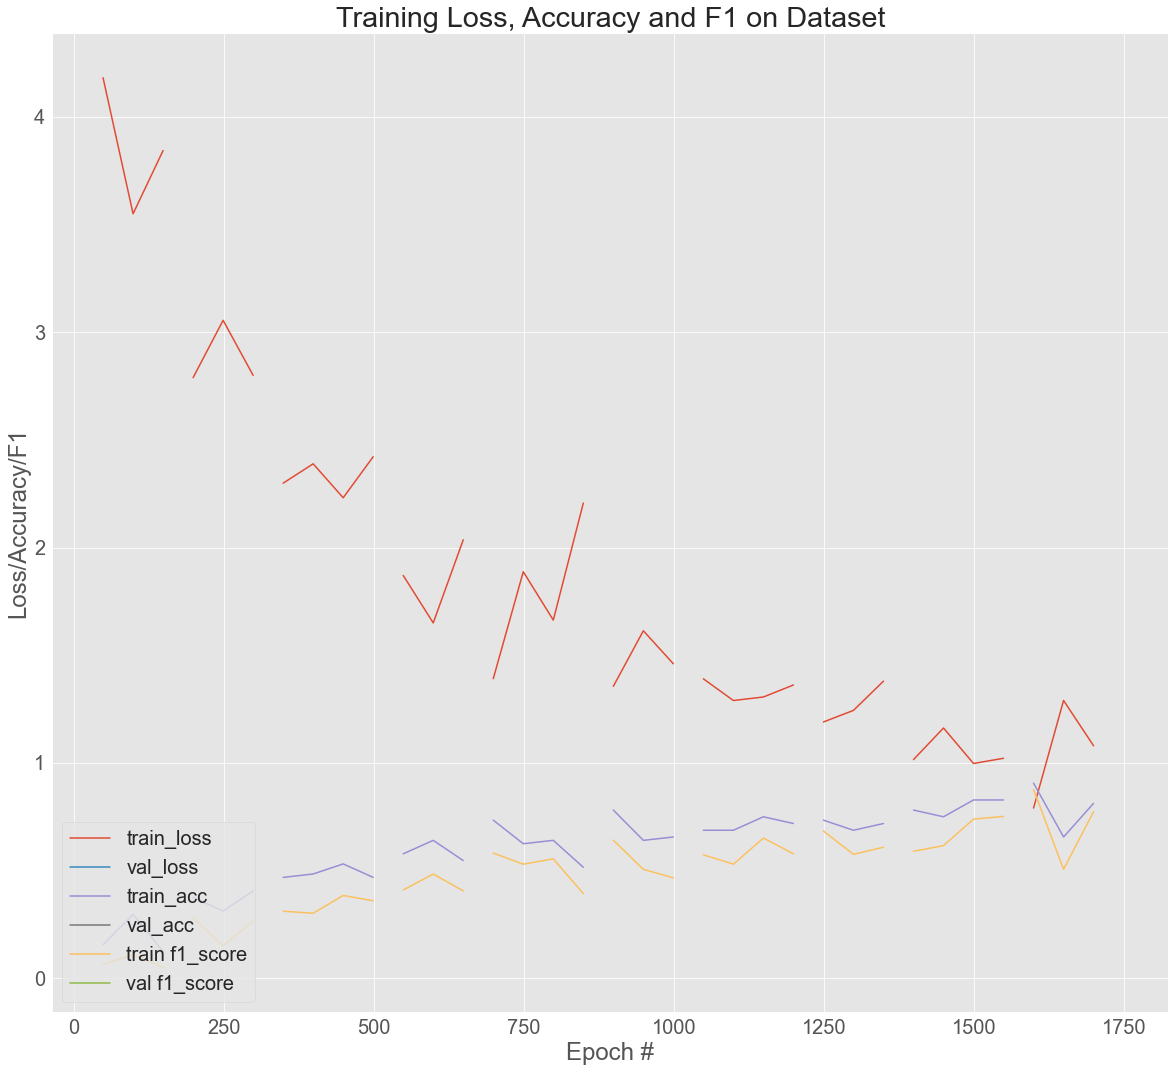

In [44]:
plt.style.use("ggplot")
plt.rcParams['font.size'] = 20
plt.figure(figsize=(20, 18))
plt.plot(metrics["train_labelsmoothingcrossentropy_step"], label="train_loss")
plt.plot(metrics["val_labelsmoothingcrossentropy"], label="val_loss")
plt.plot(metrics["train_accuracy_step"], label="train_acc")
plt.plot(metrics["val_accuracy"], label="val_acc")
plt.plot(metrics["train_f1score_step"], label="train f1_score")
plt.plot(metrics["val_f1score"], label="val f1_score")
plt.title("Training Loss, Accuracy and F1 on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy/F1")
plt.legend(loc="lower left")

<Figure size 1440x360 with 0 Axes>

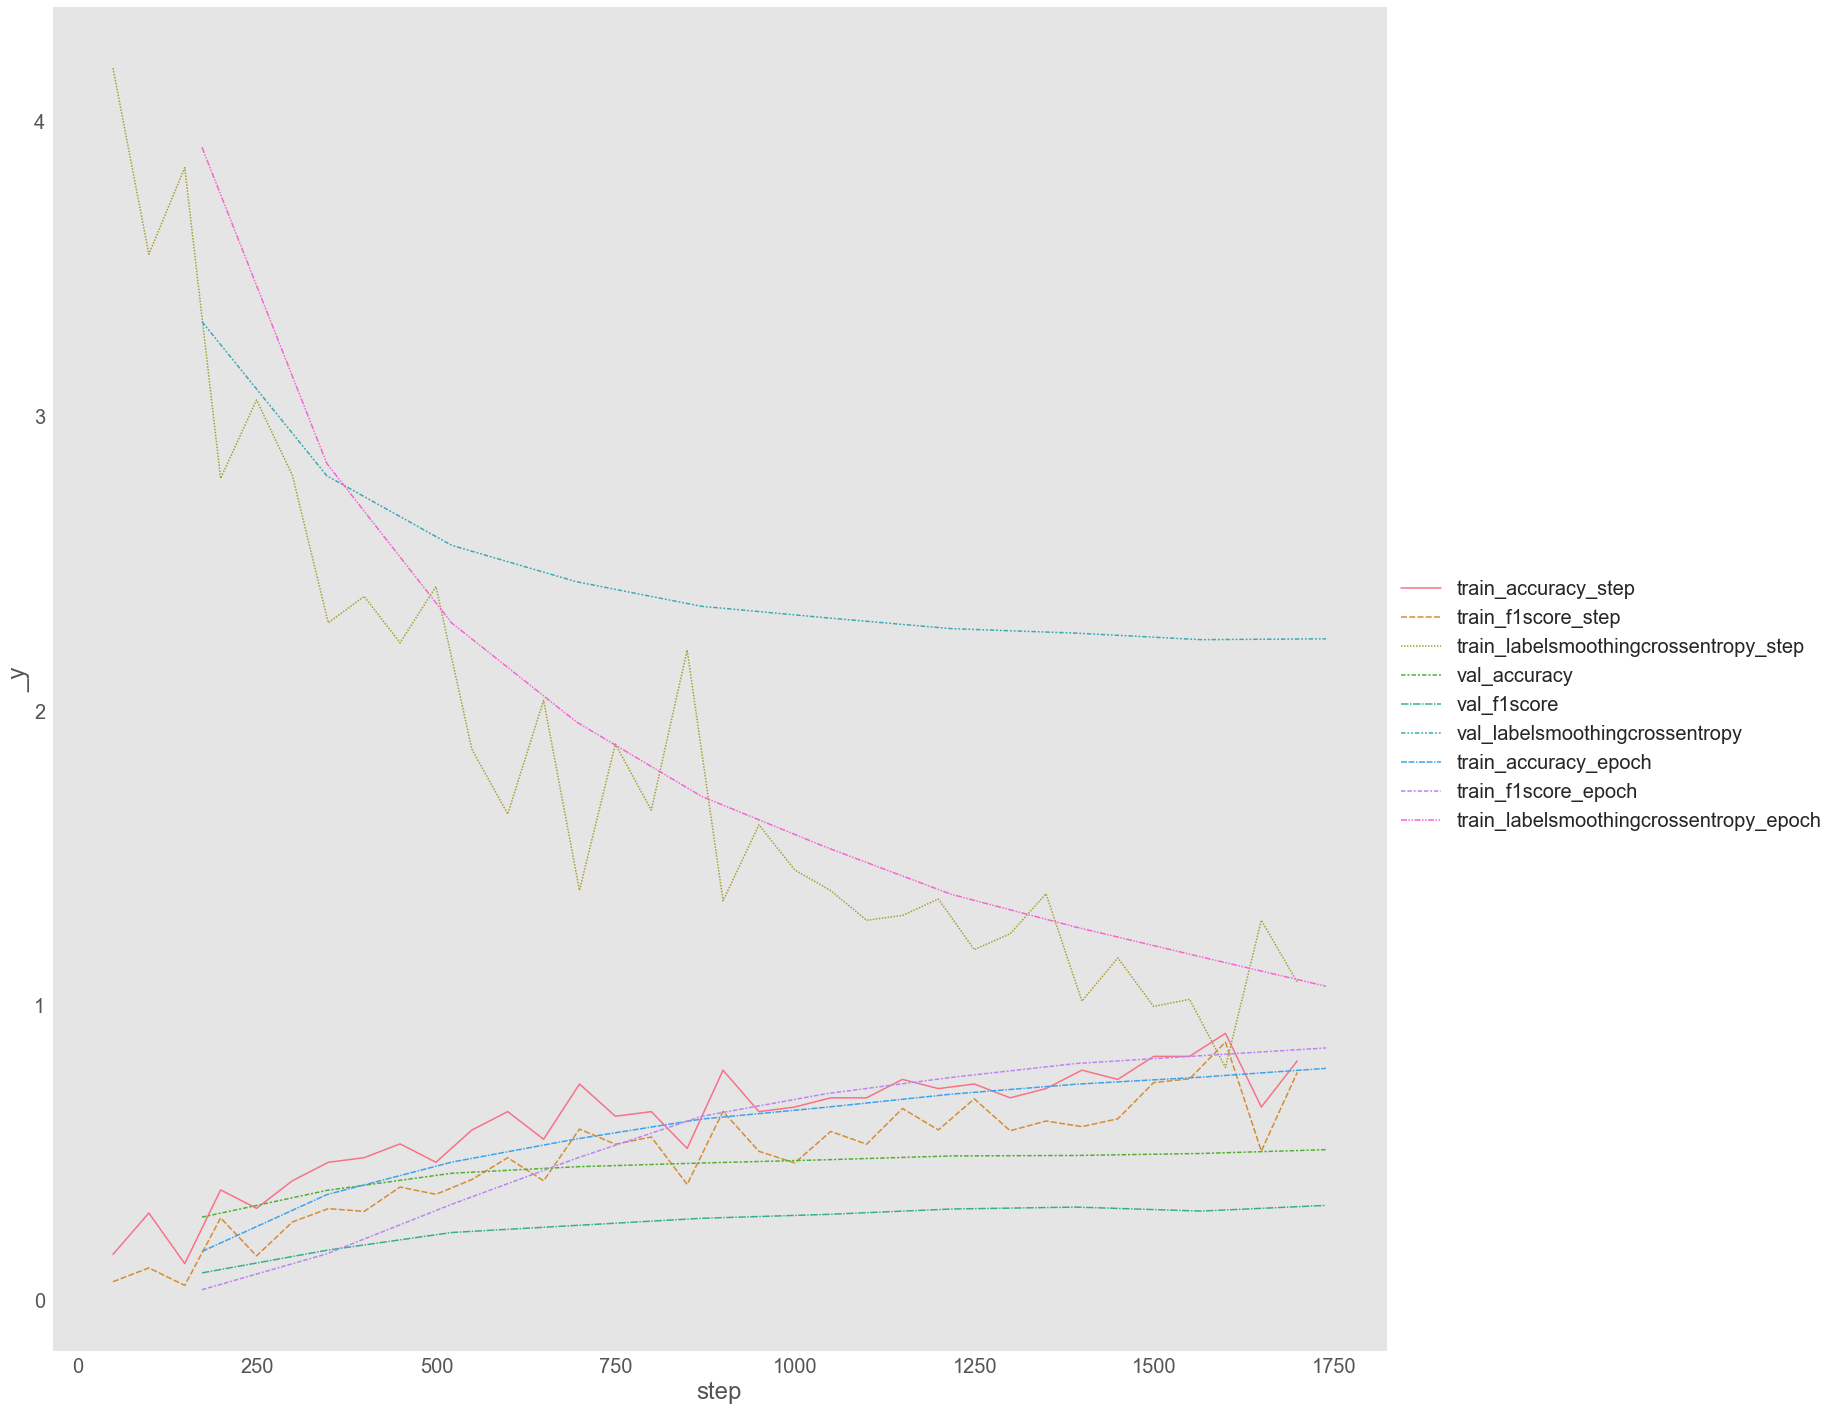

In [62]:
plt.figure(figsize=(20,5))
sns.relplot(data=metrics, kind="line", height=20)
plt.grid()